# Auswertungshilfe

Im Folgenden finden Sie Rezepte und kurze Anleitungen, die Ihnen bei der Auswertung der Daten helfen sollen. Sie können jedes beliebige Tool für die Auswertung verwenden, solange Sie zu einem brauchbaren Ergebnis kommen. Stark empfohlen wird die Verwendung von Python-Skripten.


## 1. Einlesen und Korrektur

Korrektur der Aufnahmen mittels der gewonnenen Bias-, Dark- und Flat-Aufnahmen (siehe bereitgestelltes PDF in Moodle). Hierfür können Python-Funktionen verwendet werden. Beispiele von einfachen Operationen, siehe auch die [Astropy Dokumentation](https://docs.astropy.org/en/stable/io/fits/).

Bias, Dark und Flat Korrektur werden an die Science Frames wie folgt angewandt:

$$
\mathrm{science frame} = \frac{\mathrm{raw science frame}- \mathrm{master dark} - \mathrm{master bias}}{\mathrm{master flat} /  \langle\mathrm{master flat}\rangle }
$$

In [229]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
from scipy.interpolate import interp1d
import os
import pandas as pd

ROOT = os.path.dirname(os.path.realpath("__file__"))
PATH = '/Gruppe8/'


In [230]:
#Fetch Data-Files
files = [file for file in os.listdir(ROOT+PATH) if file.endswith('fit')]

#Split Filenames for Sorting and def Sorting-Frame
tempArr = []
for file in files:
    nr = file.split('_')[0]
    if file.endswith('fit') == True:
        tempArr.append(int(nr))
    else:
        tempArr.append(None)

#Lookup DF Nr-File
fileFrame = pd.DataFrame({'Nr': tempArr, 'Files': files})
fileFrame.sort_values(['Nr', 'Files'], inplace=True)

#Fetch Data
def openFit(fileName):
    with fits.open(ROOT+PATH+fileName) as fit:
        data = fit[0].data
    return data

#Extract Header and Data from Files and prep plotable axis
Flats = pd.DataFrame(columns=['Nr', 'Flat'])
Darks = pd.DataFrame(columns=['Nr', 'Dark'])
Biases = pd.DataFrame(columns=['Nr', 'Bias'])
SunThAr = pd.DataFrame(columns=['Nr', 'Spectra'])
Filters = pd.DataFrame(columns=['Nr', 'Filter'])

#Sort Dark, Bias and Flat Files
for idx, row in fileFrame.iterrows():
    nr = row['Nr']
    fileName = row['Files']
    fitData = openFit(fileName)

    if fileName.find('bias') != -1:
        Biases.loc[len(Biases)] = [nr, fitData]

    elif fileName.find('dark') != -1:
        Darks.loc[len(Darks)] = [nr, fitData]

    elif fileName.find('flat') != -1:
        Flats.loc[len(Flats)] = [nr, fitData]

    elif fileName.find('Sun_ThAr') != -1:
        SunThAr.loc[len(SunThAr)] = [nr, fitData]

    else:
        Filters.loc[len(Filters)] = [nr, fitData]



## 2. Stacken, Extrahieren 1D Spektrum

Erstellung von gemittelten Aufnahmen zur Verbesserung des Signals und zum Zweck der Verwerfung von Ausreißern (z.B. Cosmics).

In [231]:
#Image Stacking
biasFrame = np.median(np.array(Biases['Bias'].tolist()), axis=0)
darkFrame = np.median(np.array(Darks['Dark'].tolist()), axis=0)
flatFrame = np.median(np.array(Flats['Flat'].tolist()), axis=0)
sunThArFrame = np.median(np.array(SunThAr['Spectra'].tolist()), axis=0)

#Filters in dataFrame Filters (No Stacking)


Extraktion eines 1-dimensionalen Spektrums: Von den kalibrierten Aufnahmen kann ein 1-dimensionales Spektrum extrahiert werden, indem ein Rechteck an der passenden Stelle ausgeschnitten wird. Darauf folgend berechnet man den Median entlang einer Pixelsäule.

In [232]:
#Cutout filter
cutoutFilter_F = Filters['Filter'][0][920:1220, 350:410]
filterF = np.nanmedian(cutoutFilter_F, axis=0)
cutoutFilter_I = Filters['Filter'][1][780:990, 350:410]
filterI = np.nanmedian(cutoutFilter_I, axis=0)

#Cutout Spectra
cutoutSunSpect = sunThArFrame[350:410, :]
sunSpect = np.nanmedian(cutoutSunSpect, axis=0)
cutoutThArSpect = sunThArFrame[510:570, :]
ThArSpect = np.nanmedian(cutoutThArSpect, axis=0)
cutoutFlatSpect = flatFrame[350:410, :]
flatSpect = np.nanmedian(cutoutFlatSpect, axis=0)


'''# Speichern als FITS-Tabelle
from astropy.table import Table
table = Table(data=[np.arange(len(spectrum_flat)), spectrum_flat], names=["Pixel", "Flux (ADU)"])
table.write("/path/to/table.fits")'''

'# Speichern als FITS-Tabelle\nfrom astropy.table import Table\ntable = Table(data=[np.arange(len(spectrum_flat)), spectrum_flat], names=["Pixel", "Flux (ADU)"])\ntable.write("/path/to/table.fits")'

## 3. Kombinierte Flat Korrektur

Idee: Das Flat das durch den Spektrographen aufgenommen wird enthält das Black-Body Spektrum der Tischlampe. Um dieses auszukorrigieren, nehmen wir ein zusätzliches Flat auf, das bereits korrigiert ist (Silva-Nova Spektrometer), durch welches das Spektrograph Flat dividiert werden soll. 

Dafür ist zu beachten dass das Wellenlängen-sampling der beiden Flats anders ist. Kontrollieren Sie nach in welchen Wellenlängbereichen die beiden Flats aufgenommen wurden. 

Tip: Mit Interpolieren (zB `interp1d`) kann man das erwünschte sampling für das Nova Spektrometer erhalten.

C:\Users\Julian\AppData\Local\Temp\ipykernel_4920\3567945841.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  refFlat = pd.read_csv(ROOT+PATH+"silvernova.SSM", delim_whitespace=True, names=['Wavelength', 'ADU'], skiprows=1)


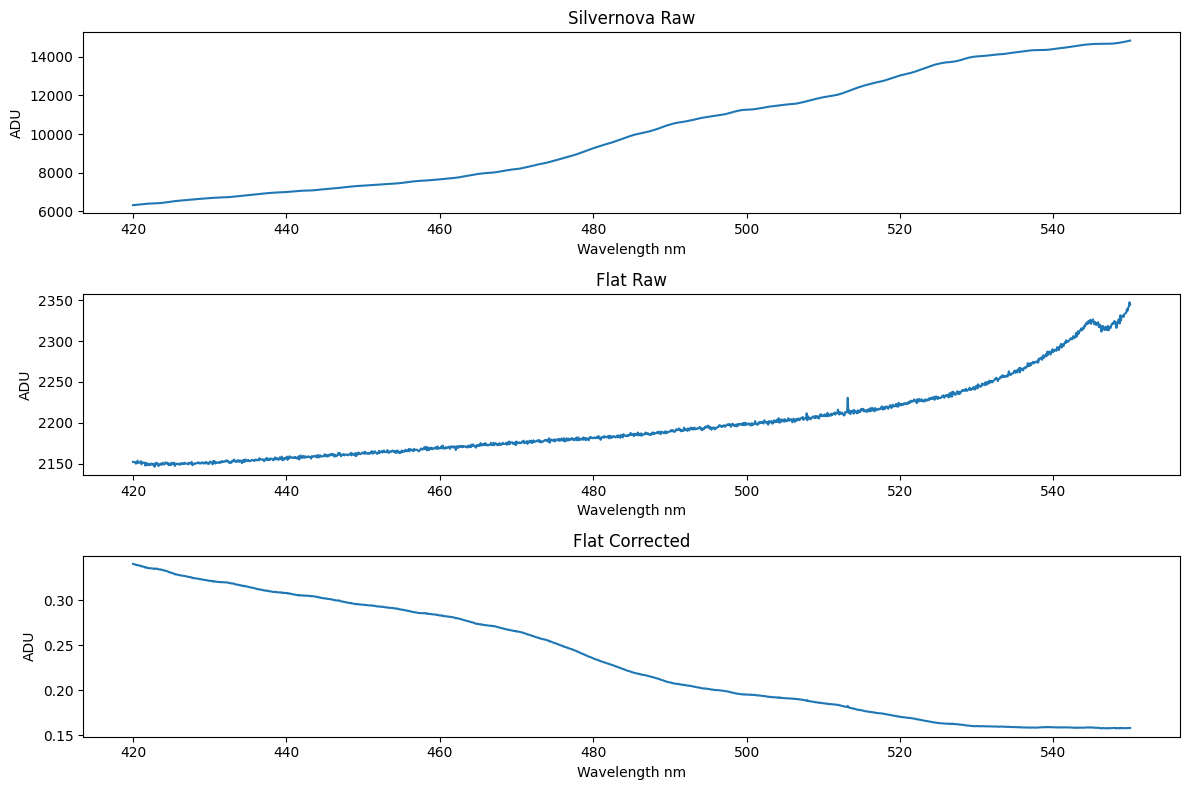

In [233]:
refFlat = pd.read_csv(ROOT+PATH+"silvernova.SSM", delim_whitespace=True, names=['Wavelength', 'ADU'], skiprows=1)
refFlat = refFlat.loc[(420 <= refFlat['Wavelength']) & (refFlat['Wavelength'] <= 550), ['Wavelength', 'ADU']]

#h = (flatSpect.max()-flatSpect.min())/(len(flatSpect)-1)
xAxis = np.linspace(420, 550, len(flatSpect))

refInterpol = interp1d(refFlat['Wavelength'], refFlat['ADU'])
flatCorrected = np.divide(flatSpect, refInterpol(xAxis))

fig, ax = plt.subplots(3, 1, figsize=(12, 8))
ax[0].plot(refFlat['Wavelength'], refFlat['ADU'])
ax[0].set_xlabel('Wavelength nm')
ax[0].set_ylabel('ADU')
ax[0].set_title('Silvernova Raw')

ax[1].plot(xAxis, flatSpect)
ax[1].set_xlabel('Wavelength nm')
ax[1].set_ylabel('ADU')
ax[1].set_title('Flat Raw')

ax[2].plot(xAxis, flatCorrected)
ax[2].set_xlabel('Wavelength nm')
ax[2].set_ylabel('ADU')
ax[2].set_title('Flat Corrected')

plt.tight_layout()
plt.show()



## 4. Wellenlängekalibration
Identifikation der ThAr-Linien. Zur Identifikation der Linien soll der beigelegte Linienatlas verwendet werden. Beachten Sie, dass das aufgenommene Spektrum Wellenlängen von 4200 bis 5500 abdeckt.

Für das finden der peaks kann zB von `scipy.signal` die funktion `find_peaks`verwendet werden.


Erstellung einer Wellenlängenkalibration auf Basis der identifizierten Linien. Hierfür erstellen Sie einen Fit zwischen Pixelkoordinaten und Wellenlänge der identifizierten Linien. Sie können hierfür numpy verwenden

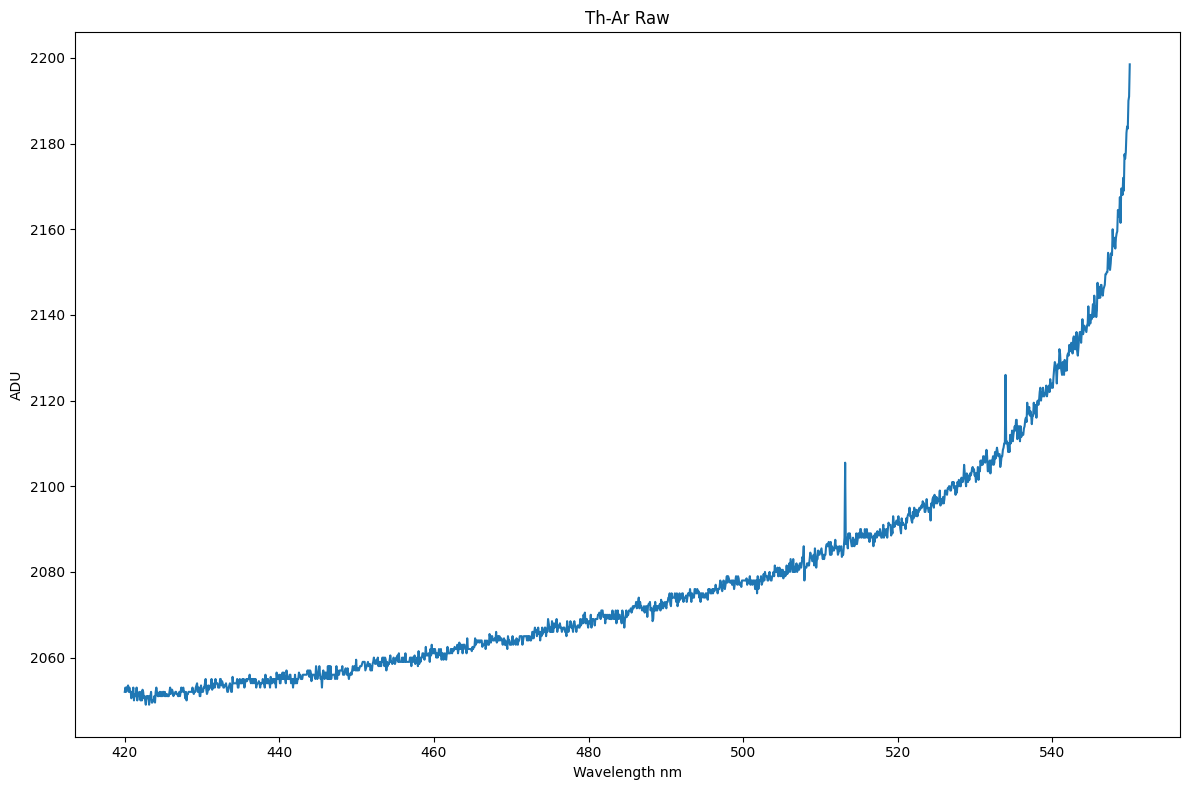

In [239]:
# Fit zwischen Pixel und Wellenlänge mittels Polynom 2. Ordnung
#coeff = np.polynomial.Polynomial.fit(pixel, wavelength, 2)


ThArCorrectedFrame = np.divide((sunThArFrame - darkFrame - biasFrame), (flatCorrected))
cutoutThArSpectCorrected = ThArCorrectedFrame[510:570, :]
ThArCorrected = np.nanmedian(cutoutThArSpectCorrected, axis=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(xAxis, ThArSpect)
ax.set_xlabel('Wavelength nm')
ax.set_ylabel('ADU')
ax.set_title('Th-Ar Raw')

plt.tight_layout()
plt.show()


Die so erstellte Interpolation kann nun verwendet werden, um die Wellenlängenkalibration auf das Sonnenspektrum anzuwenden.

In [235]:
#TODO Sun Calibration and Plot
'''ThArCorrectedFrameRaw = np.divide((sunThArFrame - darkFrame - biasFrame), (flatSpect))
cutoutThArSpectCorrectedRaw = ThArCorrectedFrameRaw[510:570, :]
ThArCorrectedRaw = np.nanmedian(cutoutThArSpectCorrectedRaw, axis=0)

ThArCorrectedFrame = np.divide((sunThArFrame - darkFrame - biasFrame), (flatCorrected))
cutoutThArSpectCorrected = ThArCorrectedFrame[510:570, :]
ThArCorrected = np.nanmedian(cutoutThArSpectCorrected, axis=0)

fig, ax = plt.subplots(3, 1, figsize=(12, 8))
ax[0].plot(xAxis, ThArSpect)
ax[0].set_xlabel('Wavelength nm')
ax[0].set_ylabel('ADU')
ax[0].set_title('Th-Ar Raw')

ax[1].plot(xAxis, ThArCorrectedRaw)
ax[1].set_xlabel('Wavelength nm')
ax[1].set_ylabel('ADU')
ax[1].set_title('Th-Ar Corrected-Raw')

ax[2].plot(xAxis, ThArCorrected)
ax[2].set_xlabel('Wavelength nm')
ax[2].set_ylabel('ADU')
ax[2].set_title('Th-Ar Corrected')

plt.tight_layout()
plt.show()'''


"ThArCorrectedFrameRaw = np.divide((sunThArFrame - darkFrame - biasFrame), (flatSpect))\ncutoutThArSpectCorrectedRaw = ThArCorrectedFrameRaw[510:570, :]\nThArCorrectedRaw = np.nanmedian(cutoutThArSpectCorrectedRaw, axis=0)\n\nThArCorrectedFrame = np.divide((sunThArFrame - darkFrame - biasFrame), (flatCorrected))\ncutoutThArSpectCorrected = ThArCorrectedFrame[510:570, :]\nThArCorrected = np.nanmedian(cutoutThArSpectCorrected, axis=0)\n\nfig, ax = plt.subplots(3, 1, figsize=(12, 8))\nax[0].plot(xAxis, ThArSpect)\nax[0].set_xlabel('Wavelength nm')\nax[0].set_ylabel('ADU')\nax[0].set_title('Th-Ar Raw')\n\nax[1].plot(xAxis, ThArCorrectedRaw)\nax[1].set_xlabel('Wavelength nm')\nax[1].set_ylabel('ADU')\nax[1].set_title('Th-Ar Corrected-Raw')\n\nax[2].plot(xAxis, ThArCorrected)\nax[2].set_xlabel('Wavelength nm')\nax[2].set_ylabel('ADU')\nax[2].set_title('Th-Ar Corrected')\n\nplt.tight_layout()\nplt.show()"

## 5. Spektrale Auflösung

Bestimmung der spektralen Auflösung aus der Breite der ThAr-Linien. Die Auflösung eines Spektrographen ist definiert durch
$$
        R \equiv \frac{\lambda}{\Delta \lambda},
$$
wobei hier R die Auflösung des Spektrographen darstellt, $\lambda$ die beobachtete Wellenlänge und $\Delta \lambda$ den kleinsten Unterschied in der Wellenlänge, den der Spektrograph auflösen kann. In der Praxis kann man für $\Delta \lambda$ die Full Width Half Maximum (FWHM) einer Linie bestimmen.

## 6. Signal-to-Noise Ratio

Abschätzung des Signal-Rausch-Verhältnisses (S/N) des Sonnenspektrums. Das S/N bei Spektren ist wegen unterschiedlicher Linienstärke wellenlängenabhängig. Die Angabe eines einzelnen S/N-Wertes für ein gesamtes Spektrum ist daher meistens nicht aussagekräftig. Zur Vereinfachung nehmen Sie an, dass die dominierende Rauschkomponente das Signal selbst ist, d.h. das Rauschen folgt einer Poissonverteilung nur abhängig vom Signal (den Gain der Kamera finden Sie im FITS-Header).